In [2]:
import numpy as np
from scipy.optimize import root
from scipy.special import jv, gamma # bessel, gamma function
from nozzle import Spectral, Params, Nozzle, Boundary
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
N = 501
Mm = 1.0
constant_v = False
accelerating = True
boundary = Boundary.FIXED_FIXED

params = Params(Mm, constant_v, accelerating, boundary)
spectral = Spectral(N, "symmetric", "FD")
nozzle = Nozzle(params, spectral.x)
D1 = spectral.D1
D2 = spectral.D2
x = spectral.x
v0 = lambda z: np.interp(z, x, nozzle.v0)
v0_p = lambda z: np.interp(z, x, D1@nozzle.v0) 
v0_pp = lambda z: np.interp(z, x, D2@nozzle.v0) 

# Expansion at singular point

$$
v(z) = b^{(1-a)/2} z^{(1-a)/2}\left[
    A_1 \Gamma(a)J_{a-1}(2\sqrt{bz})
    + A_2 \Gamma(2-a)J_{1-a}(2\sqrt{bz})
\right]
$$
where $a=2-i\omega/v_0'(0)$ and $b=v_0''(0)/v'(0)-i\omega$

In [5]:
omega = 1
z = x
a = 2 - 1j*omega/v0_p(0)
b = v0_pp(0)/v0_p(0) - 1j*omega
A1, A2 = 1,1
v = b**((1-a)/2)*z**((1-a)/2) * (
    A1*gamma(a)*jv(a-1, 2*np.sqrt(b*z))
    +A2*gamma(2-a)*jv(1-a, 2*np.sqrt(b*z))
)

plt.plot(z,v)
plt.xlabel("x")
plt.ylabel("v")
plt.title("Expansion at singular point")

/tmp/ipykernel_12151/3349500959.py:6: RuntimeWarning: invalid value encountered in power
  v = b**((1-a)/2)*z**((1-a)/2) * (


TypeError: ufunc 'jv' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

# IVP:

$$
\begin{align*}
v' &= u\\
u' &= \frac{-1}{1-v_0^2}\left[
    \omega^2v + 2i\omega(v_0+v_0'v) - \left(3v_0 - \frac{1}{v_0}\right)v_0'u - \left(1-\frac{1}{v_0}^2\right)(v_0')^2v - \left(v_0+\frac{1}{v_0}v_0'' v\right)
\right]
\end{align*}
$$
and $v(0)=c_0=1,u(0)=c_1=(2i\omega v_0'-2v_0'')/2v_0'$. Moreover, $u'(0)=c_2=-((v_0')^4+(2i\omega v_0' + (v_0')^2 - v_0'')(i\omega v_0' - v_0''))/(v_0'(2i\omega-6v_0'))$

In [5]:
def f(z: float, y: float, params: float):
    """ 
    ind: index of current position in z array
    y: [v,u] at current position
    """
    omega = params["omega"]
    c0 = params["c0"]
    c1 = params["c1"]
    c2 = params["c2"]

    v, u = y[0], y[1]
    if np.isclose(z,0):
        return np.array([
            c1,
            c2
        ])
    else:
        return np.array([
            u,
            -(
                omega**2*v + 2j*omega*(v0(z)*u+v0_p(z)*v) 
                -(3*v0(z)+1/v0(z))*v0_p(z)*u - (1-1/v0(z)**2)*v0_p(z)**2*v -(v0(z)+1/v0(z))*v0_pp(z)*v
            ) / (1-v0(z)**2)
        ])

def RK4(f: callable, z_arr: np.array, y0: np.array, params: dict, return_array: bool=True):
    """ RK4 """
    dz = z_arr[1]-z_arr[0]
    if (return_array):
        y = np.zeros((2,z_arr.size), dtype=complex)
        y[:,0] = y0
        for n, z in enumerate(z_arr[:-1]):
            yn = y[:,n]
            k1 = f(z, yn, params)
            k2 = f(z+dz/2, yn+dz*k1/2, params)
            k3 = f(z+dz/2, yn+dz*k2/2, params)
            k4 = f(z+dz, yn+dz*k3, params)
            y[:,n+1] = yn + dz*(k1+2*k2+2*k3+k4)/6
    else:
        y = y0
        for _, z in enumerate(z_arr[:-1]):
            k1 = f(z, y, params)
            k2 = f(z+dz/2, y+dz*k1/2, params)
            k3 = f(z+dz/2, y+dz*k2/2, params)
            k4 = f(z+dz, y+dz*k3, params)
            y += dz*(k1+2*k2+2*k3+k4)/6
    return y

def ivp(z_arr: np.array, omega: complex):
    a1 = -2*v0_p(0)
    a2 = 2j*omega - 4*v0_p(0)
    a3 = 2j*omega*v0_p(0)+2*v0_p(0)**2
    a4 = 2j*omega*v0_p(0) - 2*v0_pp(0)
    a5 = -2*v0_p(0)**3

    c0 = 1
    c1 = -a4/a2*c0
    c2 = -(a5*c0 + (a3+a4)*c1)/(2*(a1+a2))
    
    params = {"omega": omega, "c0": c0, "c1": c1, "c2": c2}
    y0 = np.array([c0, c1])
    return RK4(f, z_arr, y0, params, return_array=True)

def shooting(omega: np.array):
    """ omega is a size-2 array [real, imag] """
    omega = complex(*omega)
    a1 = -2*v0_p(0)
    a2 = 2j*omega - 4*v0_p(0)
    a3 = 2j*omega*v0_p(0)+2*v0_p(0)**2
    a4 = 2j*omega*v0_p(0) - 2*v0_pp(0)
    a5 = -2*v0_p(0)**3

    c0 = 1
    c1 = -a4/a2*c0
    c2 = -(a5*c0 + (a3+a4)*c1)/(2*(a1+a2))

    params = {"omega": omega, "c0": c0, "c1": c1, "c2": c2}

    z_arr = x[x<=0][::-1]
    y0 = np.array([c0, c1])
    y = RK4(f, z_arr, y0, params, return_array=False)
    # we want y[0].real = y[0].imag = 0
    return [y[0].real, y[0].imag]

In [6]:
omegas = []
for real_part in tqdm(range(0, 22, 2)):
    result = root(shooting, x0=[real_part,0])
    if (not result.success): continue
    omega = complex(*result.x)
    if (len(omegas) > 0 and np.isclose(omega, omegas[-1])): continue
    omegas.append(omega)

100%|██████████| 11/11 [01:30<00:00,  8.21s/it]


<Axes: xlabel='$\\Re(\\omega)$', ylabel='$\\Im(\\omega)$'>

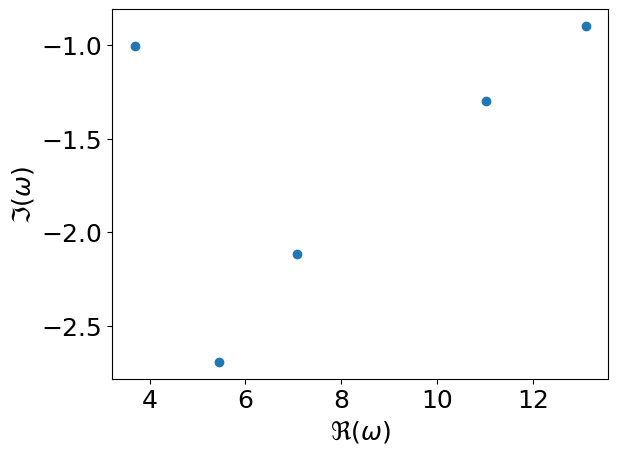

In [13]:
nozzle.omega = np.array(omegas)
nozzle.V = np.zeros((1,len(omegas)))
nozzle.sort_solutions(real_range=[0,15])
nozzle.plot_eigenvalues()

Text(0.5, 1.0, 'accelerating profile')

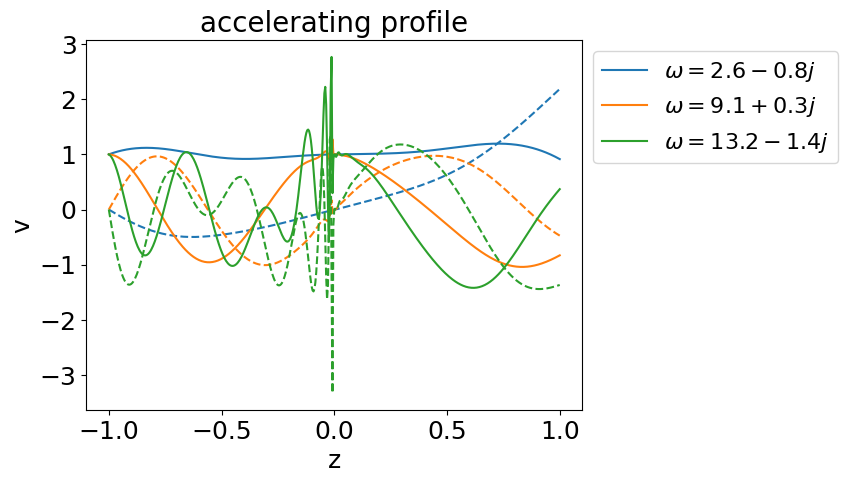

In [6]:
z_left = x[x<=0][::-1]
z_right = x[x>0]
z = x
for omega in omegas[:3]:
    y_left = ivp(z_left, omega)
    y_right = ivp(z_right, omega)
    v = np.concatenate([y_left[0][::-1], y_right[0]])
    line = plt.plot(z, v.real, label=f"$\omega={omega:.1f}$")
    plt.plot(z, v.imag, "--", color=line[0]._color)
plt.xlabel("z")
plt.ylabel("v")
plt.legend(bbox_to_anchor=(1,1))
plt.title("accelerating profile")